# Reading the Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("vader_lexicon")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
# from selenium import webdriver
# import pandas as pd
# import re

[nltk_data] Downloading package stopwords to C:\Users\MAAZ
[nltk_data]     PATEL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\MAAZ
[nltk_data]     PATEL/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\MAAZ
[nltk_data]     PATEL/nltk_data...


# Data Extraction

In [ ]:
!pip install selenium
from selenium import webdriver
import pandas as pd
import re
driver = webdriver.Chrome()
url = 'https://en.wikipedia.org/wiki/Lists_of_films'
driver.get(url)
print("Done")
from selenium.webdriver.common.by import By
Table  = driver.find_element(By.CLASS_NAME  , 'wikitable')
print(Table)
href_list = []
anchor_tags = Table.find_elements(By.TAG_NAME, 'a')
for tag in anchor_tags:
    link = tag.get_attribute("href")
    href_list.append(link)
driver.quit()
names = []
pattern = r'^[a-zA-Z0-9\s]+$'
for link in href_list:
    driver = webdriver.Chrome()
    driver.get(link)
    data_divs = driver.find_elements(By.CLASS_NAME, 'div-col')
    for data in data_divs:
        Movie_names = data.find_elements(By.TAG_NAME, 'i')
        for name in Movie_names:
            if re.match(pattern, name.text):
                names.append(name.text)
print("Done")
df = pd.DataFrame(names, columns=['column_name'])
df.to_csv("Movies.csv", index=False)
df = pd.read_csv("Movies.csv")
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from IPython.display import clear_output
url = "https://www.imdb.com/"
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--ignore-ssl-errors')
options.add_argument("--disable-web-security")
driver = webdriver.Chrome(options=options)
driver.implicitly_wait(5)
for i in range(0,2000):
    try:
        driver.get(url)
        search_box = driver.find_element(By.ID, 'suggestion-search')
        driver.implicitly_wait(5)
        search_box.send_keys(df['Name'][i])
        search_box.send_keys(Keys.RETURN)   
        driver.implicitly_wait(5)
        driver.find_elements(By.CSS_SELECTOR, "a.ipc-metadata-list-summary-item__t")[0].click()
        df.loc[i , 'rating'] = driver.find_element(By.CSS_SELECTOR, 'span.sc-bde20123-1.iZlgcd').text
        df.loc[i, 'No_of_ratings'] = driver.find_element(By.CSS_SELECTOR, 'div.sc-bde20123-3.bjjENQ').text
        scores = driver.find_elements(By.CSS_SELECTOR, 'span.score')
        # score 1 user 2 is critic
        df.loc[i,'user'] = scores[0].text
        df.loc[i,'critics'] = scores[1].text
        anchor_tags = driver.find_elements(By.CSS_SELECTOR, "a.ipc-metadata-list-item__list-content-item.ipc-metadata-list-item__list-content-item--link")
        df.loc[i, 'director'] = anchor_tags[0].text
        contributors = ''
        for tag in anchor_tags[1:]:
            contributors += tag.text
            contributors += ","
        df.loc[i, 'contributors'] = contributors
        storyLine = driver.find_elements(By.CSS_SELECTOR, 'div.ipc-html-content-inner-div')
        Movie_Info = ""
        for j in storyLine:
            Movie_Info += j.text
            Movie_Info += ","
        df.loc[i, 'Movie_Info'] = Movie_Info
        print(df)
    except Exception as E:
        clear_output(wait=True)
        continue
driver.quit()
df.to_csv("finalDf.csv", index=False)

# Reading the file and a function to convert string to Integer
We are reading only 10k records from a huge database as it takes a long tme to scrape the data.


In [2]:
columns_to_include = ['Name', 'rating', 'No_of_ratings', 'user', 'critics', 'Movie_Info']
df = pd.read_csv('finalDf.csv',usecols = columns_to_include)

In [3]:
def convert_to_int(value):
    if "K" in value:
        value = value.replace("K", "")
        value = float(value) * 1000
    elif "M" in value:
        value = value.replace("M", "")
        value = float(value) * 1000000
    else:
        pass
    return int(value)

## Defining a class for Data Wrangling and Modelling
We are using object oriented concepts by creating classes and methods for code reusability.

As part of reviews data we ae having text data which is formatted using some NLP techniques.

For Modelling we are using Random forest with Gris search tuned values.

# Usage of defined methods


In [4]:
class movie_model:

  # Defining the constants that are required for Analysis
  # These are globally declared as they can access anywhere.

  def __init__(self) -> None:
    self.df = df
    self.numeric_columns = ["rating", "No_of_ratings", "user", "critics"]
    self.text_column =  "Movie_Info"
    self.shape = self.df.shape
    self.pattern = r'[^a-zA-Z\s]'
    self.stop_words = set(stopwords.words('english'))
    self.lemmatizer = WordNetLemmatizer()
    self.score_calculation = SentimentIntensityAnalyzer()
    self.label_encoder = LabelEncoder()
    self.classifier = RandomForestClassifier()

    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None
    self.accuracy = None
    self.report = None
# '''
# Removal of NUll Values
# We are not analysins outlirs as our data is distrubuted widely and extreme values are important for our exploration purpose
# '''
  def remove_null(self):
    self.df = self.df.dropna()
    self.shape = self.df.shape

  def handle_numeric_vals(self):
    columns = ["No_of_ratings", "user"]
    for column in columns:
          self.df[column] = self.df[column].apply(convert_to_int)

#Discreating the data into 5 categories.

  def apply_descretization(self):
    for column in self.numeric_columns:
      min = np.min(self.df[column])
      max = np.max(self.df[column])
      if column == "No_of_ratings":
        bin_edges = [min, 1000, 10000,100000,1000000,max ]
        bin_labels = ["Obscure", "Very Niche", "Emerging", "Popular", "Highly Popular"]
        self.df['rating_popularity'] = pd.cut(self.df[column], bins=bin_edges, labels=bin_labels)
      if column == "user":
        bin_edges = [min, 25, 100, 500,1000, max]
        bin_labels = ["Mildly Positive", "Positive", "Very Positive", "Extremely Positive", "Exceptionally Positive"]
        self.df["user_popularity"] = pd.cut(self.df[column], bins = bin_edges, labels = bin_labels)
      if column == "critics":
        bin_edges = [min, 25, 35, 70, 200, max ]
        bin_labels = ["Favorable", "Positive", "Highly Positive", "Exceptionally Positive", "Rave Reviews"]
        self.df["critic_popularity"] = pd.cut(self.df[column], bins = bin_edges, labels = bin_labels)

  def remove_columns(self):
    columns = ["No_of_ratings", "user", "critics", "Movie_Info", "Name"]
    for column in columns:
      self.df = self.df.drop(column, axis=1)

  def perform_encoding(self):
    columns = ['rating_popularity', 'user_popularity', "critic_popularity"]
    for column in columns:
      self.df[column] = self.label_encoder.fit_transform(self.df[column])

# '''
# As these are categories and number of user_reviews we ae using PIE charts for better visualization.
# '''
  def draw_pie_chart(self, column):
    if column == 'critic_popularity':
        explode = (0, 0.1, 0,0,0)
    else:
        explode = (0, 0, 0, 0, 0.3)
    categories = self.df[column].value_counts().index
    plt.title(column)
    plt.pie(self.df[column].value_counts(), labels=categories, shadow=True, autopct='%1.1f%%', explode=explode, wedgeprops={'edgecolor': 'black'})
    plt.axis('equal')
    plt.show()

  def draw_heat_map(self, X, Y):
    crosstab = pd.crosstab(self.df[X], self.df[Y])
    sns.heatmap(crosstab, annot=True, cmap='YlGnBu')
    plt.show()

# NLP Data preprocessing

  def apply_lower_case(self):
    self.df[self.text_column] = self.df[self.text_column].apply(lambda string: string.lower())

  def clean_text(self):
    self.df[self.text_column] = self.df[self.text_column].apply(lambda string: re.sub(self.pattern, '', string))

  def tokenize(self):
    self.df[self.text_column] = self.df[self.text_column].apply(lambda string: string.split())

  def handle_stop_words(self):
    self.df[self.text_column] = self.df[self.text_column].apply(lambda string: [word for word in string if word not in self.stop_words])

  def apply_lematization(self):
    self.df[self.text_column] = self.df[self.text_column].apply(lambda words: [self.lemmatizer.lemmatize(word) for word in words ])

#Sentiment analysis of the reviewed data

  def get_sentiment_score(self):
    self.df['Movie_Info'] = self.df['Movie_Info'].apply(lambda words: " ".join(words))
    self.df['sentiment_score'] = self.df['Movie_Info'].apply(lambda string: self.score_calculation.polarity_scores(string)['compound'] )

#Splitting the source data

  def perform_train_test_split(self):
    X = self.df[['rating_popularity', 'critic_popularity', 'sentiment_score', 'rating']]
    y = self.df['user_popularity']
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Modelling the data

  def train_classifier(self):
    # self.classifier.fit(self.X_train, self.y_train)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    grid_search = GridSearchCV(estimator=self.classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(self.X_train, self.y_train)
    # print("Best Parameters: ", grid_search.best_params_)
    self.classifier = grid_search.best_estimator_

#Predicting and evaluating thre results.

  def make_prediction(self):
    self.y_pred = self.classifier.predict(self.X_test)

  def evaluate_model(self):
    self.accuracy = accuracy_score(self.y_test, self.y_pred)
    self.report = classification_report(self.y_test, self.y_pred)

  def visualize_result(self):
    cm = confusion_matrix(self.y_test, self.y_pred)
    labels = ["Mildly Positive", "Positive", "Very Positive", "Extremely Positive", "Exceptionally Positive"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels = labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#Instance creation of the class

movieObject = movie_model()

In [5]:
movieObject.remove_null()
movieObject.handle_numeric_vals()
movieObject.apply_descretization()
movieObject.apply_lower_case()
movieObject.clean_text()
movieObject.tokenize()
movieObject.handle_stop_words()
movieObject.apply_lematization()
movieObject.get_sentiment_score()
movieObject.remove_columns()

C:\Users\MAAZ PATEL\AppData\Local\Temp\ipykernel_11248\1375252916.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[column] = self.df[column].apply(convert_to_int)
C:\Users\MAAZ PATEL\AppData\Local\Temp\ipykernel_11248\1375252916.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['rating_popularity'] = pd.cut(self.df[column], bins=bin_edges, labels=bin_labels)
C:\Users\MAAZ PATEL\AppData\Local\Temp\ipykernel_11248\1375252916.py:50: SettingWithCopyWarning: 
A value is trying to be set on

In [6]:
movieObject.df.columns

Index(['rating', 'rating_popularity', 'user_popularity', 'critic_popularity',
       'sentiment_score'],
      dtype='object')

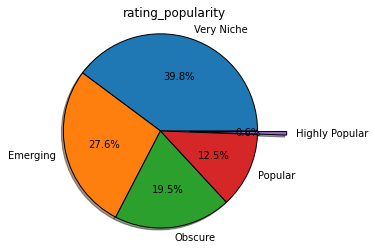

In [7]:
movieObject.draw_pie_chart('rating_popularity')

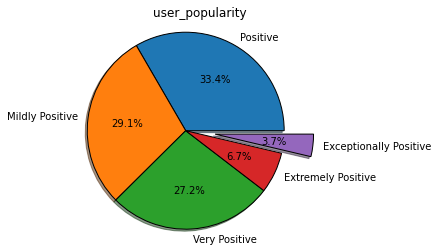

In [8]:
movieObject.draw_pie_chart('user_popularity')

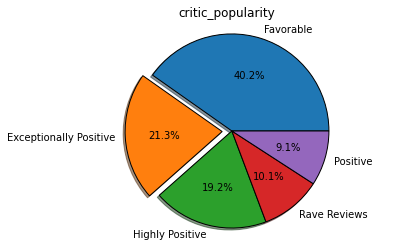

In [9]:
movieObject.draw_pie_chart('critic_popularity')

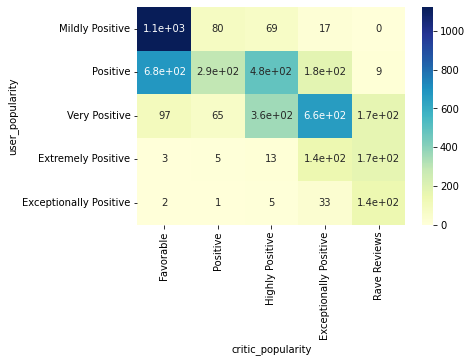

In [10]:
movieObject.draw_heat_map("user_popularity", "critic_popularity")

In [11]:
movieObject.perform_encoding()
movieObject.perform_train_test_split()
movieObject.train_classifier()
movieObject.make_prediction()
movieObject.evaluate_model()

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\MAAZ PATEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MAAZ PATEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MAAZ PATEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
movieObject.accuracy

0.69009900990099

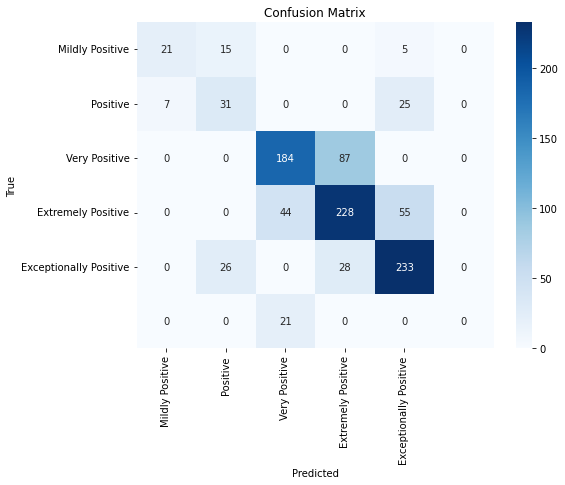

In [13]:
movieObject.visualize_result()